In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Data

In [2]:
# Load main datasets
learn_data = pd.read_csv("learn_dataset.csv", index_col=0)

# Define paths to your CSV files
data_files = {
    "learn_dataset": "learn_dataset.csv",
    "learn_emp_contract": "learn_dataset_Emp_contract.csv",
    "learn_job": "learn_dataset_job.csv",
    "learn_retired_former": "learn_dataset_retired_former.csv",
    "learn_retired_jobs": "learn_dataset_retired_jobs.csv",
    "learn_retired_pension": "learn_dataset_retired_pension.csv",
    "learn_sport": "learn_dataset_sport.csv"
}

# Load datasets into a dictionary
datasets = {}
for name, path in data_files.items():
    datasets[name] = pd.read_csv(path)
    
city_adm = pd.read_csv("city_adm.csv", encoding="utf-8").drop(columns=["Dep"])
city_loc = pd.read_csv("city_loc.csv", encoding="utf-8")
city_pop = pd.read_csv("city_pop.csv", encoding="utf-8")
departments = pd.read_csv("departments.csv", encoding="utf-8")
regions = pd.read_csv("regions.csv", encoding="utf-8")

In [3]:
target_column = 'target'
if target_column not in learn_data.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset.")

## Merge for Learn Data

In [4]:
# Merge job contract data
learn_data = learn_data.merge(datasets["learn_emp_contract"], how="left", on="Unique_id")

In [5]:
# Rename columns from the two datasets to avoid conflicts
learn_retired_jobs_renamed = datasets["learn_retired_jobs"].rename(columns={
    'COMPANY_CATEGORY': 'retired_COMPANY_CATEGORY',
    'JOB_CONDITION': 'retired_JOB_CONDITION',
    'activity_sector': 'retired_activity_sector',
    'Job_category': 'retired_Job_category',
    'working_hours': 'retired_working_hours',
    'EMPLOYEE_COUNT': 'retired_EMPLOYEE_COUNT',
    'job_desc': 'retired_job_desc',
    'Job_dep': 'retired_Job_dep',
    'Contract_type': 'retired_Contract_type'
})

learn_dataset_job_renamed = datasets["learn_job"].rename(columns={
    'COMPANY_CATEGORY': 'job_COMPANY_CATEGORY',
    'JOB_CONDITION': 'job_JOB_CONDITION',
    'activity_sector': 'job_activity_sector',
    'Job_category': 'job_Job_category',
    'working_hours': 'job_working_hours',
    'EMPLOYEE_COUNT': 'job_EMPLOYEE_COUNT',
    'job_desc': 'job_job_desc',
    'Job_dep': 'job_Job_dep',
    'Contract_type': 'job_Contract_type'
})

# Now merge `learn_retired_jobs` and `learn_dataset_job` with `learn_dataset`
learn_data = learn_data.merge(learn_retired_jobs_renamed, how="left", on="Unique_id")
learn_data = learn_data.merge(learn_dataset_job_renamed, how="left", on="Unique_id")

# Combine the relevant columns
learn_data["COMPANY_CATEGORY"] = learn_data["retired_COMPANY_CATEGORY"].fillna(learn_data["job_COMPANY_CATEGORY"])
learn_data["JOB_CONDITION"] = learn_data["retired_JOB_CONDITION"].fillna(learn_data["job_JOB_CONDITION"])
learn_data["activity_sector"] = learn_data["retired_activity_sector"].fillna(learn_data["job_activity_sector"])
learn_data["Job_category"] = learn_data["retired_Job_category"].fillna(learn_data["job_Job_category"])
learn_data["working_hours"] = learn_data["retired_working_hours"].fillna(learn_data["job_working_hours"])
learn_data["EMPLOYEE_COUNT"] = learn_data["retired_EMPLOYEE_COUNT"].fillna(learn_data["job_EMPLOYEE_COUNT"])
learn_data["job_desc"] = learn_data["retired_job_desc"].fillna(learn_data["job_job_desc"])
learn_data["Job_dep"] = learn_data["retired_Job_dep"].fillna(learn_data["job_Job_dep"])
learn_data["Contract_type"] = learn_data["retired_Contract_type"].fillna(learn_data["job_Contract_type"])

# Drop the redundant columns after merging
learn_data.drop(columns=[
    'retired_COMPANY_CATEGORY', 'job_COMPANY_CATEGORY', 
    'retired_JOB_CONDITION', 'job_JOB_CONDITION', 
    'retired_activity_sector', 'job_activity_sector', 
    'retired_Job_category', 'job_Job_category',
    'retired_working_hours', 'job_working_hours', 
    'retired_EMPLOYEE_COUNT', 'job_EMPLOYEE_COUNT', 
    'retired_job_desc', 'job_job_desc', 
    'retired_Job_dep', 'job_Job_dep', 
    'retired_Contract_type', 'job_Contract_type'
], inplace=True)

# Now `learn_data` should have the combined columns, and we no longer have duplicates

In [6]:
learn_data = learn_data.merge(datasets["learn_retired_former"], how="left", on="Unique_id")
learn_data = learn_data.merge(datasets["learn_retired_pension"], how="left", on="Unique_id")
learn_data = learn_data.merge(datasets["learn_sport"], how="left", on="Unique_id")

In [7]:
code_job_42 = pd.read_csv("code_job_42.csv", encoding="utf-8")
code_job_42.rename(columns={"Code": "job_42", "Libellé": "job_description_42"}, inplace=True)

In [8]:
# Merge the dataframes
learn_data = learn_data.merge(code_job_42, how="left", on="job_42")
# Fill missing job descriptions
learn_data["job_description_42"] = learn_data["job_description_42"].fillna("Unknown")

In [9]:
# Ensure the 'insee_code' column is treated as a string
learn_data["insee_code"] = learn_data["insee_code"].astype(str)

# Create the 'Dep' column by extracting the first two characters
learn_data["Dep"] = learn_data["insee_code"].str[:2]

learn_data = learn_data.merge(departments, how="left", on="Dep")
learn_data = learn_data.merge(regions, how="left", on="REG")
learn_data = learn_data.merge(city_loc, how="left", on="insee_code")
learn_data = learn_data.merge(city_adm, how="left", on="insee_code")
learn_data = learn_data.merge(city_pop, how="left", on="insee_code")

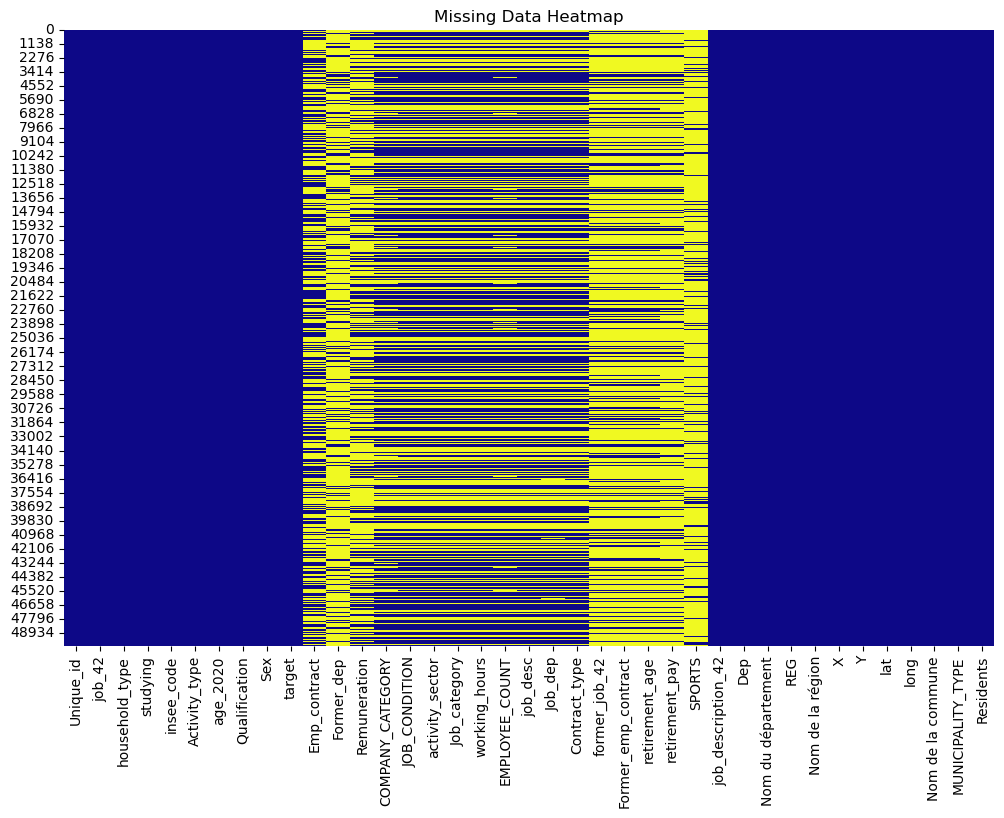

In [10]:
# Visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(learn_data.isnull(), cbar=False, cmap="plasma")
plt.title("Missing Data Heatmap")
plt.show()

In [11]:
# Fill missing numerical values with 0 (e.g., no pension)
numerical_cols = learn_data.select_dtypes(include=["float", "int"]).columns
learn_data[numerical_cols] = learn_data[numerical_cols].fillna(0)

# Fill missing categorical values with "Unknown"
categorical_cols = learn_data.select_dtypes(include=["object"]).columns
learn_data[categorical_cols] = learn_data[categorical_cols].fillna("Unknown")


In [12]:
learn_data.shape

(50046, 39)

## Merge for Test Data

In [13]:
# Load main datasets
test_data = pd.read_csv("test_dataset.csv", index_col=0)

# Define paths to your CSV files
data_files = {
    "test_dataset": "test_dataset.csv",
    "test_emp_contract": "test_dataset_Emp_contract.csv",
    "test_job": "test_dataset_job.csv",
    "test_retired_former": "test_dataset_retired_former.csv",
    "test_retired_jobs": "test_dataset_retired_jobs.csv",
    "test_retired_pension": "test_dataset_retired_pension.csv",
    "test_sport": "test_dataset_sport.csv"
}

# Load datasets into a dictionary
datasets = {}
for name, path in data_files.items():
    datasets[name] = pd.read_csv(path)

In [14]:
# Merge job contract data
test_data = test_data.merge(datasets["test_emp_contract"], how="left", on="Unique_id")

In [15]:
# Rename columns from the two datasets to avoid conflicts
test_retired_jobs_renamed = datasets["test_retired_jobs"].rename(columns={
    'COMPANY_CATEGORY': 'retired_COMPANY_CATEGORY',
    'JOB_CONDITION': 'retired_JOB_CONDITION',
    'activity_sector': 'retired_activity_sector',
    'Job_category': 'retired_Job_category',
    'working_hours': 'retired_working_hours',
    'EMPLOYEE_COUNT': 'retired_EMPLOYEE_COUNT',
    'job_desc': 'retired_job_desc',
    'Job_dep': 'retired_Job_dep',
    'Contract_type': 'retired_Contract_type'
})

test_dataset_job_renamed = datasets["test_job"].rename(columns={
    'COMPANY_CATEGORY': 'job_COMPANY_CATEGORY',
    'JOB_CONDITION': 'job_JOB_CONDITION',
    'activity_sector': 'job_activity_sector',
    'Job_category': 'job_Job_category',
    'working_hours': 'job_working_hours',
    'EMPLOYEE_COUNT': 'job_EMPLOYEE_COUNT',
    'job_desc': 'job_job_desc',
    'Job_dep': 'job_Job_dep',
    'Contract_type': 'job_Contract_type'
})

# Now merge `learn_retired_jobs` and `learn_dataset_job` with `learn_dataset`
test_data = test_data.merge(test_retired_jobs_renamed, how="left", on="Unique_id")
test_data = test_data.merge(test_dataset_job_renamed, how="left", on="Unique_id")

# Combine the relevant columns
test_data["COMPANY_CATEGORY"] = test_data["retired_COMPANY_CATEGORY"].fillna(test_data["job_COMPANY_CATEGORY"])
test_data["JOB_CONDITION"] = test_data["retired_JOB_CONDITION"].fillna(test_data["job_JOB_CONDITION"])
test_data["activity_sector"] = test_data["retired_activity_sector"].fillna(test_data["job_activity_sector"])
test_data["Job_category"] = test_data["retired_Job_category"].fillna(test_data["job_Job_category"])
test_data["working_hours"] = test_data["retired_working_hours"].fillna(test_data["job_working_hours"])
test_data["EMPLOYEE_COUNT"] = test_data["retired_EMPLOYEE_COUNT"].fillna(test_data["job_EMPLOYEE_COUNT"])
test_data["job_desc"] = test_data["retired_job_desc"].fillna(test_data["job_job_desc"])
test_data["Job_dep"] = test_data["retired_Job_dep"].fillna(test_data["job_Job_dep"])
test_data["Contract_type"] = test_data["retired_Contract_type"].fillna(test_data["job_Contract_type"])

# Drop the redundant columns after merging
test_data.drop(columns=[
    'retired_COMPANY_CATEGORY', 'job_COMPANY_CATEGORY', 
    'retired_JOB_CONDITION', 'job_JOB_CONDITION', 
    'retired_activity_sector', 'job_activity_sector', 
    'retired_Job_category', 'job_Job_category',
    'retired_working_hours', 'job_working_hours', 
    'retired_EMPLOYEE_COUNT', 'job_EMPLOYEE_COUNT', 
    'retired_job_desc', 'job_job_desc', 
    'retired_Job_dep', 'job_Job_dep', 
    'retired_Contract_type', 'job_Contract_type'
], inplace=True)

# Now `learn_data` should have the combined columns, and you no longer have duplicates

In [16]:
test_data = test_data.merge(datasets["test_retired_former"], how="left", on="Unique_id")
test_data = test_data.merge(datasets["test_retired_pension"], how="left", on="Unique_id")
test_data = test_data.merge(datasets["test_sport"], how="left", on="Unique_id")

In [17]:
code_job_42 = pd.read_csv("code_job_42.csv", encoding="utf-8")
code_job_42.rename(columns={"Code": "job_42", "Libellé": "job_description_42"}, inplace=True)

In [18]:
# Merge the dataframes
test_data = test_data.merge(code_job_42, how="left", on="job_42")
# Fill missing job descriptions
test_data["job_description_42"] = test_data["job_description_42"].fillna("Unknown")

In [19]:
# Ensure the 'insee_code' column is treated as a string
test_data["insee_code"] = test_data["insee_code"].astype(str)

# Create the 'Dep' column by extracting the first two characters
test_data["Dep"] = test_data["insee_code"].str[:2]

test_data = test_data.merge(departments, how="left", on="Dep")
test_data = test_data.merge(regions, how="left", on="REG")
test_data = test_data.merge(city_loc, how="left", on="insee_code")
test_data = test_data.merge(city_adm, how="left", on="insee_code")
test_data = test_data.merge(city_pop, how="left", on="insee_code")

In [20]:
# Fill missing numerical values with 0 (e.g., no pension)
numerical_cols = test_data.select_dtypes(include=["float", "int"]).columns
test_data[numerical_cols] = test_data[numerical_cols].fillna(0)

# Fill missing categorical values with "Unknown"
categorical_cols = test_data.select_dtypes(include=["object"]).columns
test_data[categorical_cols] = test_data[categorical_cols].fillna("Unknown")

## Testing (1/3) - Random Forest

We save the predictions to predictions.csv in the code cell below. However, note that in Testing (3/3) - XGB, we also save the predictions to predictions.csv and XGB prediction is trusted more by us since it has higher accuracy on learn dataset

In [21]:
#test_data.to_csv('data_merged.csv', index=0)
learn_data = learn_data.sample(frac=1, random_state=42)

In [22]:
# Separate features and target for training
X = learn_data.drop(columns=['Unique_id', 'target'])
y = learn_data['target']

if 'target' in test_data.columns:
    test_data = test_data.drop(columns=['target'])

# Apply Ordinal Encoding to categorical features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[X.select_dtypes(include=['object', 'category']).columns] = encoder.fit_transform(
    X.select_dtypes(include=['object', 'category'])
)

# Split training data for model evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# Evaluate the model
rf_preds_eval = rf.predict(X_eval)
print("Random Forest Accuracy:", accuracy_score(y_eval, rf_preds_eval))

# Process the test dataset
X_test = test_data.drop(columns=['Unique_id'])
X_test[X_test.select_dtypes(include=['object', 'category']).columns] = encoder.transform(
    X_test.select_dtypes(include=['object', 'category'])
)

# Predict on the test set
test_data['target'] = rf.predict(X_test)

# Save predictions to CSV
predictions = test_data[['Unique_id', 'target']]
predictions.to_csv("predictions.csv", index=False)

Random Forest Accuracy: 0.8348785166240409


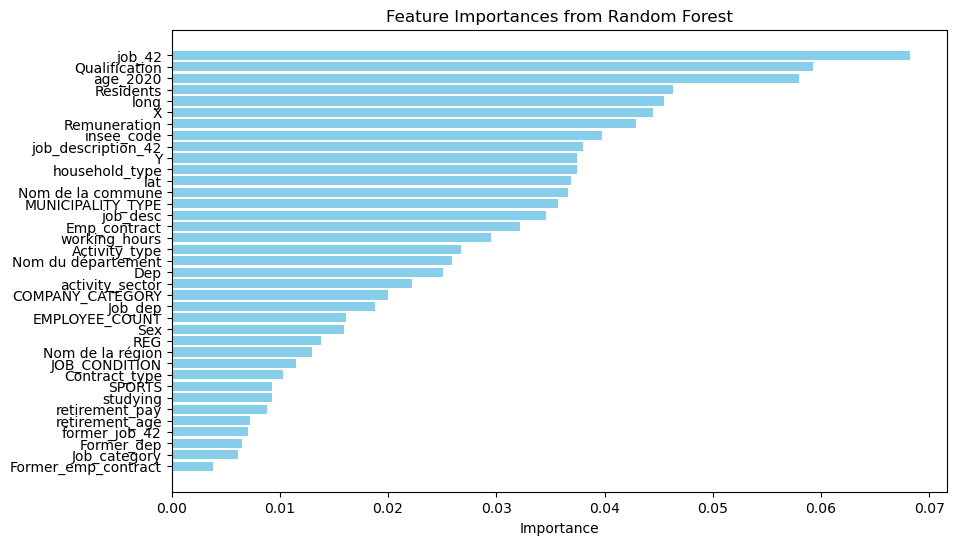

In [23]:
# Get feature importances from the Random Forest model
feature_importances = rf.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

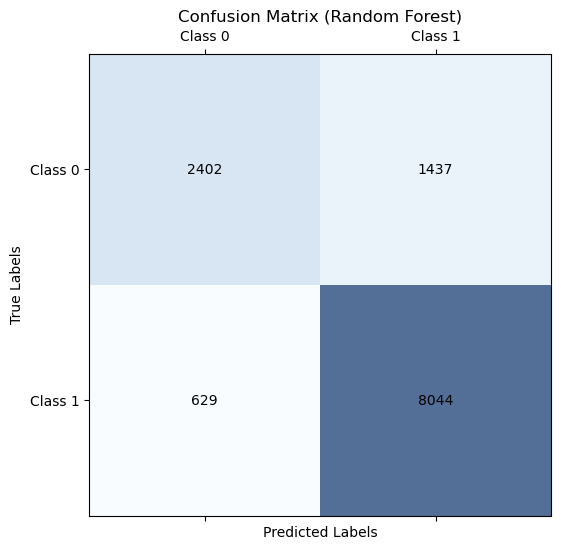

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_eval, rf_preds_eval)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (Random Forest)')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.set_yticklabels(['Class 0', 'Class 1'])
plt.show()

### Grid search and cross-fold validation

Please note that here we are tuning only on a few parameters, we ran a different parameter grid, with much more parameters. However, since it takes too much time to run we saved its plot and presented it in our report.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.8338040016013476


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


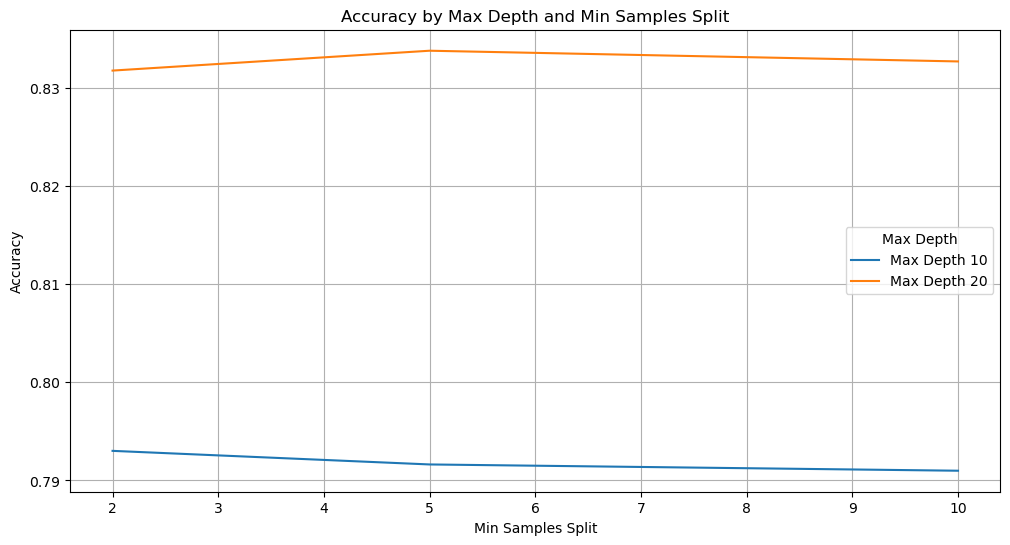

In [51]:
# Define the parameter grid
dt_grid = {
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 20]
}

# Set up the GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=dt_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=1  # Show progress
)

# Perform the grid search on the training data
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Collect results for plotting
results = rf_grid_search.cv_results_
depths = dt_grid['max_depth']
splits = [2, 5] + list(range(10, 250, 5))

# Accuracy by max_depth and min_samples_split
accuracy_grid = np.zeros((len(depths), len(splits)))
for i, depth in enumerate(depths):
    for j, split in enumerate(splits):
        mask = (results['param_max_depth'] == depth) & (results['param_min_samples_split'] == split)
        accuracy_grid[i, j] = np.mean(results['mean_test_score'][mask])

# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
for i, depth in enumerate(depths):
    ax.plot(splits, accuracy_grid[i, :], label=f"Max Depth {depth}")

ax.set_xlabel("Min Samples Split")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by Max Depth and Min Samples Split")
ax.legend(title="Max Depth")
plt.grid()
plt.show()


In [52]:
from sklearn.model_selection import cross_val_score

# Train Random Forest with cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.83335553 0.82882643 0.83228986 0.83815106 0.8346656 ]
Mean Cross-validation Accuracy: 0.8334576972319396


## Testing (2/3) - Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, class_weight="balanced", max_iter=10000)
log_reg.fit(X_train, y_train)

# Evaluate the model
log_reg_preds_eval = log_reg.predict(X_eval)
print("Logistic Regression Accuracy:", accuracy_score(y_eval, log_reg_preds_eval))

# Predict on the test set
test_data['target'] = log_reg.predict(X_test)

# Save predictions to CSV
predictions = test_data[['Unique_id', 'target']]

Logistic Regression Accuracy: 0.6894181585677749


## Testing (3/3) - eXtreme Gradient Boosting

In [26]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# Separate features and target for training
X = learn_data.drop(columns=['Unique_id', 'target'])
y = learn_data['target']

# Encode the target variable as numeric labels
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)  # Transform 'L' -> 0 and 'T' -> 1

if 'target' in test_data.columns:
    test_data = test_data.drop(columns=['target'])

# Apply Ordinal Encoding to categorical features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[X.select_dtypes(include=['object', 'category']).columns] = encoder.fit_transform(
    X.select_dtypes(include=['object', 'category'])
)

# Split training data for model evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=1)  # scale_pos_weight for handling imbalance
xgb_model.fit(X_train, y_train)

# Evaluate the model
xgb_preds_eval = xgb_model.predict(X_eval)
print("XGBoost Accuracy:", accuracy_score(y_eval, xgb_preds_eval))

# Process the test dataset
X_test = test_data.drop(columns=['Unique_id'])
X_test[X_test.select_dtypes(include=['object', 'category']).columns] = encoder.transform(
    X_test.select_dtypes(include=['object', 'category'])
)

# Predict on the test set
test_data['target'] = target_encoder.inverse_transform(xgb_model.predict(X_test))  # Convert back to 'L'/'T'

# Save predictions to CSV
predictions = test_data[['Unique_id', 'target']]
predictions.to_csv("predictions.csv", index=False)

XGBoost Accuracy: 0.875


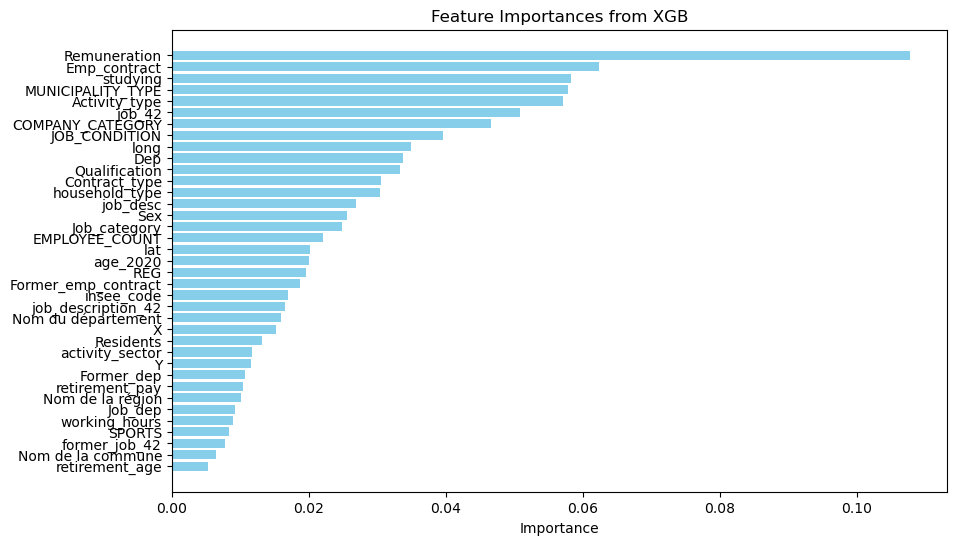

In [27]:
# Get feature importances from the Random Forest model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from XGB')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

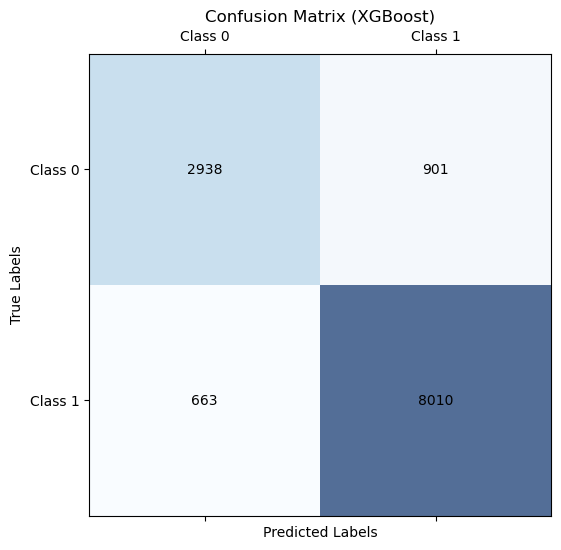

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_eval, xgb_preds_eval)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (XGBoost)')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.set_yticklabels(['Class 0', 'Class 1'])
plt.show()

### hyperparams and cross_fold validation

Here as well:

Please note that here we are tuning only on a few parameters, we ran a different parameter grid, with much more parameters. However, since it takes too much time to run we saved its plot and presented it in our report.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best Parameters: {'learning_rate': 0.2, 'max_depth': 15, 'min_child_weight': 10}
Best Cross-Validation Accuracy: 0.8784567710158502


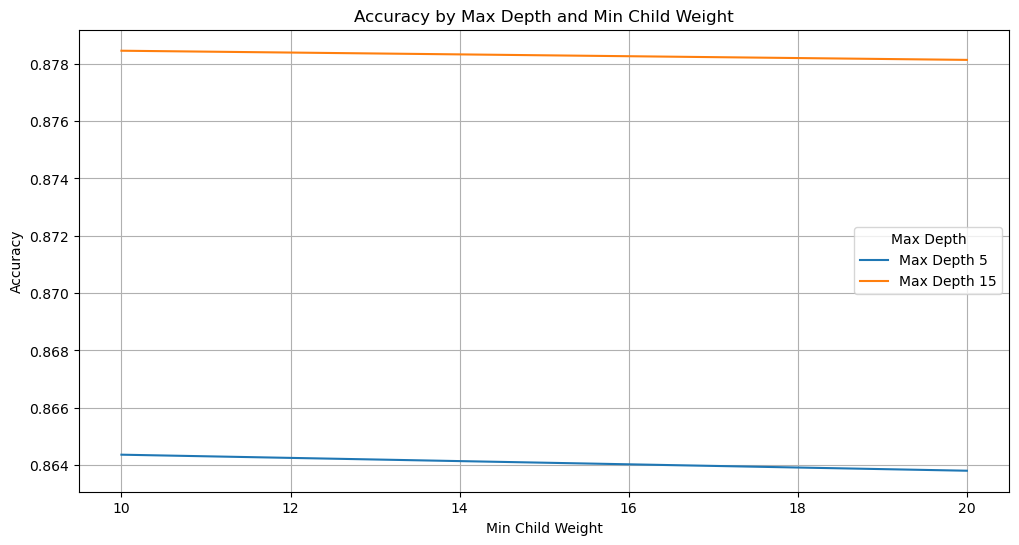

In [60]:
# Define the parameter grid
xgb_grid = {
    'max_depth': [5, 15],
    'min_child_weight': [10, 20],
    'learning_rate': [0.2] 
}

# Set up the GridSearchCV
xgb_grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=1  # Show progress
)

# Perform the grid search on the training data
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = xgb_grid_search.best_params_
best_score = xgb_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Collect results for plotting
results = xgb_grid_search.cv_results_
depths = xgb_grid['max_depth']
min_child_weights = xgb_grid['min_child_weight']

# Accuracy by max_depth and min_child_weight
accuracy_grid = np.zeros((len(depths), len(min_child_weights)))
for i, depth in enumerate(depths):
    for j, min_child_weight in enumerate(min_child_weights):
        mask = (results['param_max_depth'] == depth) & (results['param_min_child_weight'] == min_child_weight)
        accuracy_grid[i, j] = np.mean(results['mean_test_score'][mask])

# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
for i, depth in enumerate(depths):
    ax.plot(min_child_weights, accuracy_grid[i, :], label=f"Max Depth {depth}")

ax.set_xlabel("Min Child Weight")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by Max Depth and Min Child Weight")
ax.legend(title="Max Depth")
plt.grid()
plt.show()

In [61]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.87558279 0.87784734 0.87411749 0.87944585 0.87077005]
Average Cross-Validation Accuracy: 0.8755527046769849


In [29]:
# Count the number of 'L' and 'T' in target columns
learn_target_counts = learn_data['target'].value_counts()
test_target_counts = test_data['target'].value_counts()

print("Learn Data - Target Counts:")
print(learn_target_counts)

print("\nTest Data - Target Counts:")
print(test_target_counts)

# Calculate the average remuneration for 'L' and 'T' in learn_data
learn_avg_remuneration_L = learn_data[learn_data['target'] == 'L']['Remuneration'].mean()
learn_avg_remuneration_T = learn_data[learn_data['target'] == 'T']['Remuneration'].mean()

# Calculate the average remuneration for 'L' and 'T' in test_data
test_avg_remuneration_L = test_data[test_data['target'] == 'L']['Remuneration'].mean()
test_avg_remuneration_T = test_data[test_data['target'] == 'T']['Remuneration'].mean()

print("\nAverage Remuneration for 'L' and 'T' in Learn Data:")
print(f"L: {learn_avg_remuneration_L}")
print(f"T: {learn_avg_remuneration_T}")

print("\nAverage Remuneration for 'L' and 'T' in Test Data:")
print(f"L: {test_avg_remuneration_L}")
print(f"T: {test_avg_remuneration_T}")


Learn Data - Target Counts:
target
T    34623
L    15423
Name: count, dtype: int64

Test Data - Target Counts:
target
T    36560
L    13484
Name: count, dtype: int64

Average Remuneration for 'L' and 'T' in Learn Data:
L: 13912.485378979447
T: 6454.171822199116

Average Remuneration for 'L' and 'T' in Test Data:
L: 15509.271877781073
T: 6210.7590536105035


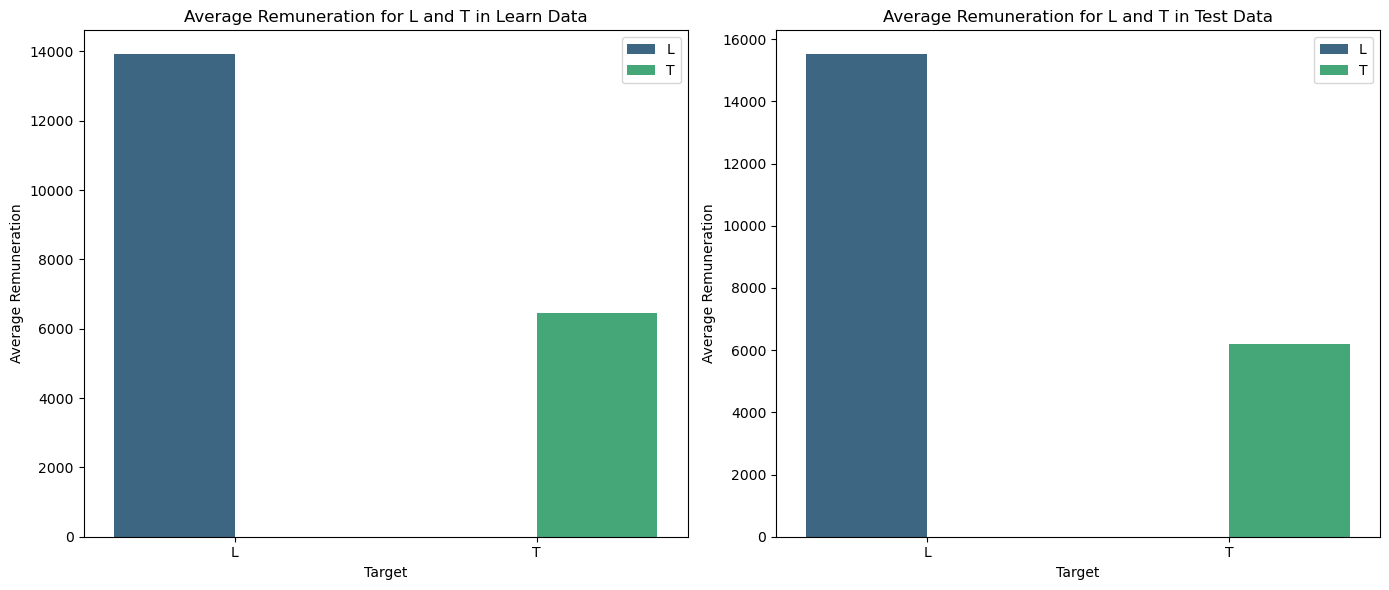

In [30]:
# Plot average remuneration for L and T in learn_data and test_data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for learn_data
sns.barplot(x=['L', 'T'], y=[learn_avg_remuneration_L, learn_avg_remuneration_T], palette="viridis", hue=['L', 'T'], ax=axes[0])
axes[0].set_title('Average Remuneration for L and T in Learn Data')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Average Remuneration')

# Plot for test_data
sns.barplot(x=['L', 'T'], y=[test_avg_remuneration_L, test_avg_remuneration_T], palette="viridis", hue=['L', 'T'], ax=axes[1])
axes[1].set_title('Average Remuneration for L and T in Test Data')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Average Remuneration')

plt.tight_layout()
plt.show()

# More Descriptive Statistics

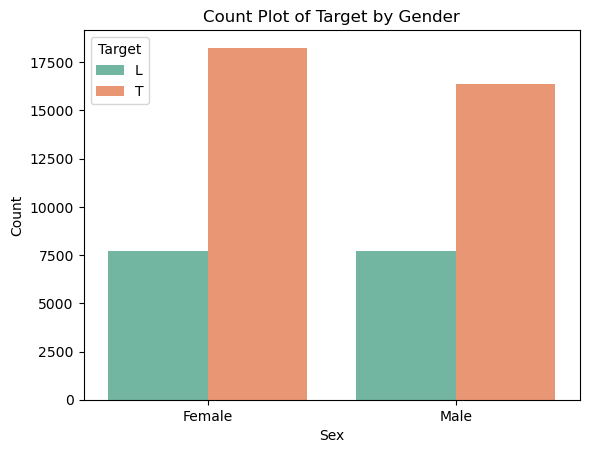

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=learn_data, x="Sex", hue="target", palette="Set2")
plt.title("Count Plot of Target by Gender")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Target")
plt.show()


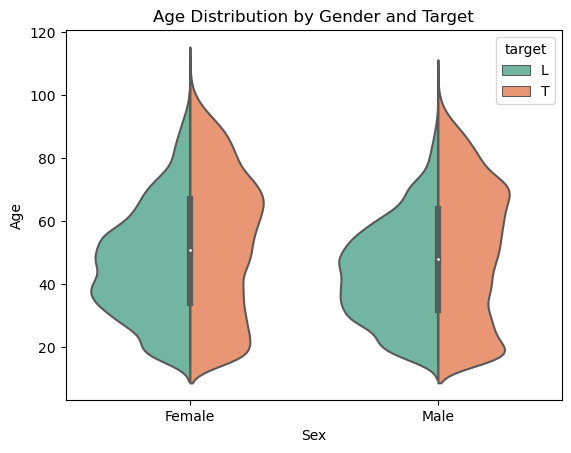

In [37]:
sns.violinplot(data=learn_data, x="Sex", y="age_2020", hue="target", split=True, palette="Set2")
plt.title("Age Distribution by Gender and Target")
plt.xlabel("Sex")
plt.ylabel("Age")
plt.show()


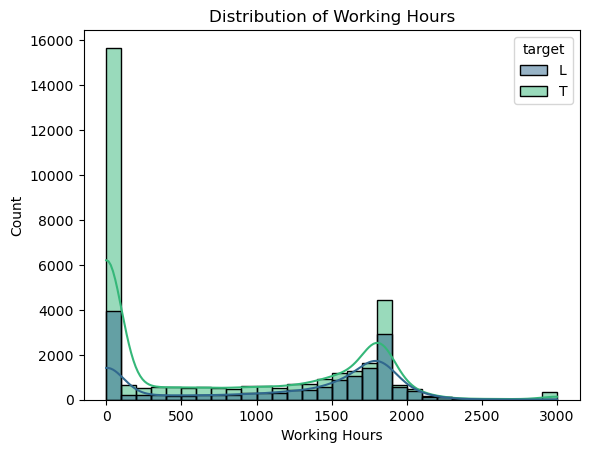

In [38]:
# Plot distribution of working hours
sns.histplot(data=learn_data, x="working_hours", hue="target", kde=True, bins=30, palette="viridis")
plt.title("Distribution of Working Hours")
plt.xlabel("Working Hours")
plt.ylabel("Count")
plt.show()


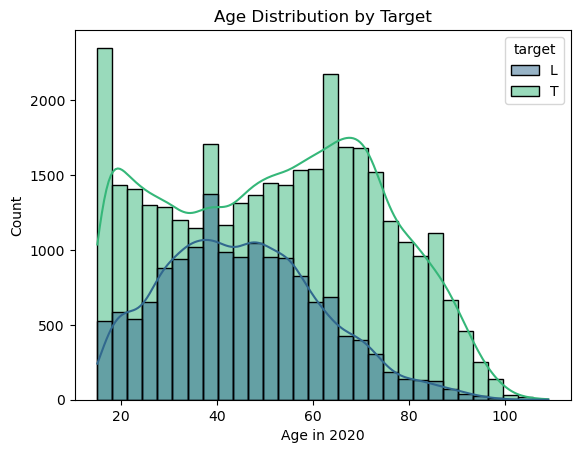

In [39]:
sns.histplot(data=learn_data, x="age_2020", hue="target", kde=True, bins=30, palette="viridis")
plt.title("Age Distribution by Target")
plt.xlabel("Age in 2020")
plt.ylabel("Count")
plt.show()

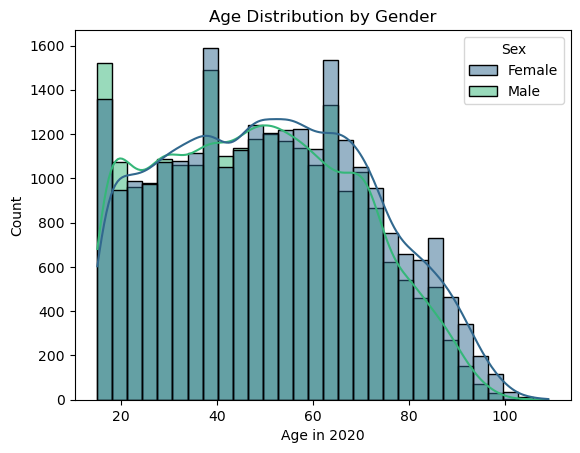

In [40]:
sns.histplot(data=learn_data, x="age_2020", hue="Sex", kde=True, bins=30, palette="viridis")
plt.title("Age Distribution by Gender")
plt.xlabel("Age in 2020")
plt.ylabel("Count")
plt.show()

In [42]:
# Calculate descriptive statistics for Age
age_mean = learn_data['age_2020'].mean()
age_std = learn_data['age_2020'].std()
print(f"Distribution of Age: The average age of individuals in the dataset is approximately {age_mean:.2f} years, with a standard deviation of {age_std:.2f}, indicating a moderate spread in age distribution.")

# Analyze Working Hours distribution
working_hours_skewness = learn_data['working_hours'].skew()
print(f"Working Hours: The working hours variable exhibited a {'right-skewed' if working_hours_skewness > 0 else 'left-skewed' if working_hours_skewness < 0 else 'symmetric'} distribution, suggesting that a subset of individuals work significantly longer hours than the majority.")

# Compute Remuneration statistics
remuneration_mean = learn_data['Remuneration'].mean()
remuneration_max = learn_data['Remuneration'].max()
print(f"Remuneration: The remuneration variable showed considerable variation, with a mean value of {remuneration_mean:.2f} and a maximum of {remuneration_max:.2f}, highlighting potential outliers in income distribution.")


Distribution of Age: The average age of individuals in the dataset is approximately 49.74 years, with a standard deviation of 20.64, indicating a moderate spread in age distribution.
Working Hours: The working hours variable exhibited a right-skewed distribution, suggesting that a subset of individuals work significantly longer hours than the majority.
Remuneration: The remuneration variable showed considerable variation, with a mean value of 8752.65 and a maximum of 349684.00, highlighting potential outliers in income distribution.


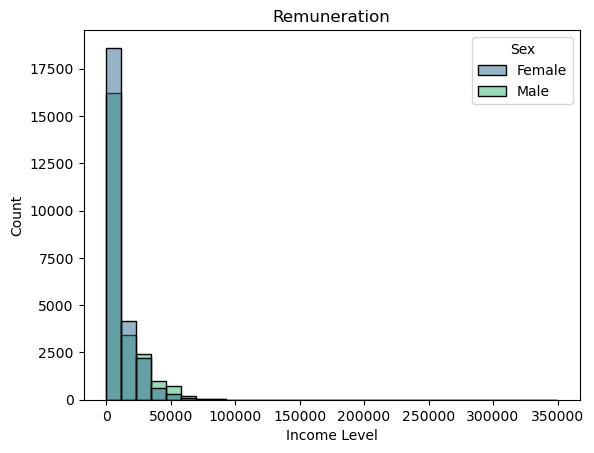

In [43]:
sns.histplot(data=learn_data, x="Remuneration", hue="Sex", bins=30, palette="viridis")
plt.title("Remuneration")
plt.xlabel("Income Level")
plt.ylabel("Count")
plt.show()

In [45]:
# Calculate sex distribution
sex_distribution = learn_data['Sex'].value_counts(normalize=True) * 100
male_percentage = sex_distribution.get('Male', 0)
female_percentage = sex_distribution.get('Female', 0)
print(f"Sex: The dataset comprises {male_percentage:.2f}% male and {female_percentage:.2f}% female individuals.")

# Calculate target variable distribution
target_distribution = learn_data['target'].value_counts(normalize=True) * 100
class_L_percentage = target_distribution.get('L', 0)
class_T_percentage = target_distribution.get('T', 0)
print(f"Target Variable Distribution: The target variable is distributed as follows: {class_L_percentage:.2f}% belong to class 'L', and {class_T_percentage:.2f}% belong to class 'T', indicating a potential class imbalance that was accounted for during the modeling phase.")


Sex: The dataset comprises 48.07% male and 51.93% female individuals.
Target Variable Distribution: The target variable is distributed as follows: 30.82% belong to class 'L', and 69.18% belong to class 'T', indicating a potential class imbalance that was accounted for during the modeling phase.


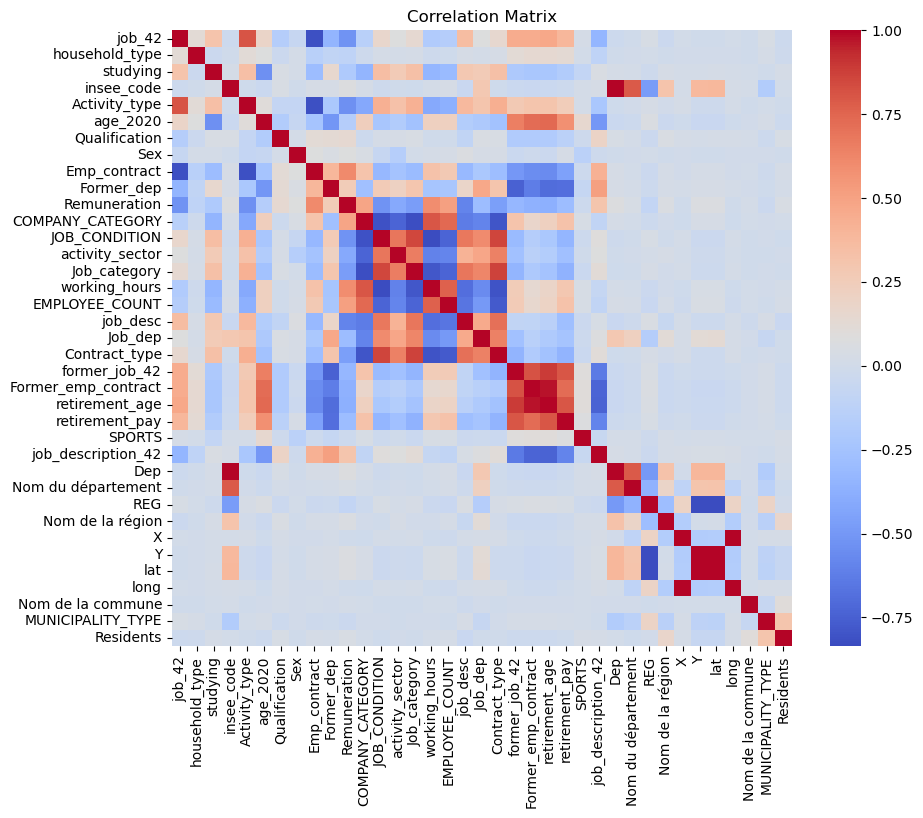

In [46]:
# Compute the correlation matrix (only numerical columns)
corr_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()